# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):

    ### STUDENT START ###

    # Fetch the data and labels for training examples
    train_data = newsgroups_train.data
    train_labels = newsgroups_train.target
    target_names = newsgroups_train.target_names

    # Print the first x = 'num_examples' training examples
    for i in range(num_examples):
        print(f"Label: {target_names[train_labels[i]]}")
        print(f"Text: {train_data[i]}")
        print("\n" + "-"*80 + "\n")

    ### STUDENT END ###

Q1(5)

Label: comp.graphics
Text: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

--------------------------------------------------------------------------------

Label: talk.religion.misc
Text: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fr

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary?
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary.
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors.
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.

In [4]:
def Q2():

    ### STUDENT START ###

    # Part 1: Transform the training data into a matrix of word unigram feature vectors
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)

    # Size of the vocabulary
    vocab_size = len(vectorizer.get_feature_names_out())

    # Average number of non-zero features per example
    avg_nonzero = X_train.nnz / X_train.shape[0]

    # Fraction of the non-zero entries in the matrix
    frac_nonzero = X_train.nnz / (X_train.shape[0] * X_train.shape[1])

    # 0th and last feature strings (in alphabetical order)
    feature_names = vectorizer.get_feature_names_out()
    first_feature = feature_names[0]
    last_feature = feature_names[-1]

    print("Size of the vocabulary:", vocab_size)
    print("Average number of non-zero features per example:", avg_nonzero)
    print("Fraction of non-zero entries in the matrix:", frac_nonzero)
    print("0th feature string:", first_feature)
    print("Last feature string:", last_feature)

    # Part 2: Restricting vocabulary to specific words
    restricted_vocab = ["atheism", "graphics", "space", "religion"]
    vectorizer_restricted = CountVectorizer(vocabulary=restricted_vocab)
    X_train_restricted = vectorizer_restricted.fit_transform(train_data)

    # Confirm the size of the vocabulary
    restricted_vocab_size = len(vectorizer_restricted.get_feature_names_out())

    # Average number of non-zero features per example
    avg_nonzero_restricted = X_train_restricted.nnz / X_train_restricted.shape[0]

    print("Size of the restricted vocabulary:", restricted_vocab_size)
    print("Average number of non-zero features per example (restricted):", avg_nonzero_restricted)

    # Part 3: Character bigram and trigram feature vectors
    vectorizer_char = CountVectorizer(analyzer='char', ngram_range=(2, 3))
    X_train_char = vectorizer_char.fit_transform(train_data)

    # Size of the vocabulary
    char_vocab_size = len(vectorizer_char.get_feature_names_out())

    print("Size of the character bigram and trigram vocabulary:", char_vocab_size)

    # Part 4: Prune words that appear in fewer than 10 documents
    vectorizer_pruned = CountVectorizer(min_df=10)
    X_train_pruned = vectorizer_pruned.fit_transform(train_data)

    # Size of the vocabulary
    pruned_vocab_size = len(vectorizer_pruned.get_feature_names_out())

    print("Size of the pruned vocabulary:", pruned_vocab_size)

    # Part 5: Fraction of words in the development vocabulary that is missing from the training vocabulary
    dev_vectorizer = CountVectorizer()
    X_dev = dev_vectorizer.fit_transform(dev_data)

    train_vocab = set(vectorizer.get_feature_names_out())
    dev_vocab = set(dev_vectorizer.get_feature_names_out())

    missing_vocab_fraction = len(dev_vocab - train_vocab) / len(dev_vocab)

    print("Fraction of words in the development vocabulary missing from the training vocabulary:", missing_vocab_fraction)

    ### STUDENT END ###

Q2()

Size of the vocabulary: 26879
Average number of non-zero features per example: 96.70599803343165
Fraction of non-zero entries in the matrix: 0.0035978272269590263
0th feature string: 00
Last feature string: zyxel
Size of the restricted vocabulary: 4
Average number of non-zero features per example (restricted): 0.26843657817109146
Size of the character bigram and trigram vocabulary: 35478
Size of the pruned vocabulary: 3064
Fraction of words in the development vocabulary missing from the training vocabulary: 0.24787640034470024


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def Q3():

    ### STUDENT START ###

    # Transform the training and development data to matrices of word unigram feature vectors
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    print(X_train.shape)
    print(X_dev.shape)

    # List of k values for k-Nearest Neighbors
    k_values = [1, 3, 4, 5, 6, 7, 9, 10, 20]
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, train_labels)
        pred = knn.predict(X_dev)
        f1 = metrics.f1_score(dev_labels, pred, average="weighted")
        print(f"k={k}, k-NN F1 Score: {f1}")

    # List of alpha values for Naive Bayes
    alpha_values = [0.1, 0.5, 1.0, 5.0, 10.0]
    for alpha in alpha_values:
        nb = MultinomialNB(alpha=alpha)
        nb.fit(X_train, train_labels)
        pred = nb.predict(X_dev)
        f1 = metrics.f1_score(dev_labels, pred, average="weighted")
        print(f"alpha={alpha}, Naive Bayes F1 Score: {f1}")

    # List of C values for Logistic Regression
    C_values = [0.01, 0.1, 1, 10, 100]
    best_lr = (0, 0)
    for C in C_values:
        lr = LogisticRegression(C=C, solver="liblinear", multi_class="auto")
        lr.fit(X_train, train_labels)
        pred = lr.predict(X_dev)
        f1 = metrics.f1_score(dev_labels, pred, average="weighted")
        if f1 > best_lr[1]:
            best_lr = (C, f1)
        print(f"C={C}, Logistic Regression F1 Score: {f1}, Sum of Squared Weights: {str((lr.coef_**2).sum(axis=1))}")

    ### STUDENT END ###

Q3()

(2034, 26879)
(676, 26879)
k=1, k-NN F1 Score: 0.3805030018531525
k=3, k-NN F1 Score: 0.4084150225437623
k=4, k-NN F1 Score: 0.4031227993847515
k=5, k-NN F1 Score: 0.4287607236218357
k=6, k-NN F1 Score: 0.4466650540867595
k=7, k-NN F1 Score: 0.45047910006117586
k=9, k-NN F1 Score: 0.4365666176198027
k=10, k-NN F1 Score: 0.4278502905941064
k=20, k-NN F1 Score: 0.4243419588207676
alpha=0.1, Naive Bayes F1 Score: 0.7903052385098862
alpha=0.5, Naive Bayes F1 Score: 0.7862862961995258
alpha=1.0, Naive Bayes F1 Score: 0.7777320236017224
alpha=5.0, Naive Bayes F1 Score: 0.7234892095047329
alpha=10.0, Naive Bayes F1 Score: 0.6674814338256576
C=0.01, Logistic Regression F1 Score: 0.6646997417582748, Sum of Squared Weights: [2.54153099 2.93970937 2.86246912 2.25002927]
C=0.1, Logistic Regression F1 Score: 0.6966243542418833, Sum of Squared Weights: [27.12953099 24.66144866 27.45885093 23.02655794]
C=1, Logistic Regression F1 Score: 0.6960862519544118, Sum of Squared Weights: [166.99355522 130.89

ANSWER:

- K-Nearest Neighbors generally doesn't work well for text classification problems due to the high dimensionality of text data and the sparsity of the feature vectors. The distance metrics used in k-NN are not well-suited for sparse and high-dimensional data, which often leads to poor performance.

- Logistic Regression may not work as well as Naive Bayes for text classification due to the nature of text data. Naive Bayes assumes word independence and tends to work well with the high dimensionality and sparsity of text data. Logistic Regression, while powerful, can be less effective when the data does not have a clear linear decision boundary.

- The sum of squared weights in Logistic Regression generally decreases as the regularization strength (C value) increases. A higher C value means less regularization (more flexibility for the model), leading to larger weight values and thus a higher sum of squared weights. Conversely, a lower C value increases regularization, which penalizes larger weights, leading to a lower sum of squared weights.

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value.


In [6]:
def Q4():

    ### STUDENT START ###

    # Transform the data to a matrix of word bigram feature vectors
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)

    # Produce a Logistic Regression model
    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(X_train, train_labels)

    # Get the feature names and weights
    feature_names = vectorizer.get_feature_names_out()
    coefs = lr.coef_

    # Find the 5 features with the largest weights for each topic
    top_features_indices = np.argsort(coefs, axis=1)[:, -5:]
    top_features_indices = top_features_indices.flatten()
    top_features = np.array(feature_names)[top_features_indices]

    # Create a table of the weights for the top features
    weights_table = pd.DataFrame(index=top_features, columns=newsgroups_train.target_names)

    for i, topic in enumerate(newsgroups_train.target_names):
        for feature in top_features:
            if feature in feature_names:
                weights_table.loc[feature, topic] = coefs[i, vectorizer.vocabulary_[feature]]
            else:
                weights_table.loc[feature, topic] = 0

    print(weights_table)

    ### STUDENT END ###

Q4()

              alt.atheism comp.graphics sci.space talk.religion.misc
are you          0.446953     -0.248257 -0.097135          -0.305625
you are           0.47274     -0.279894 -0.481305           0.028373
was just          0.48205     -0.131418 -0.128882          -0.227469
cheers kent       0.55572     -0.697918 -0.663766           0.534808
claim that       0.605549     -0.199067 -0.274345          -0.140364
is there        -0.340882      0.754998 -0.468249          -0.257079
out there       -0.274803      0.758658 -0.479057          -0.277089
comp graphics   -0.292166      0.801208 -0.370885          -0.285186
in advance      -0.459351      0.832567 -0.438501          -0.418453
looking for     -0.630341      1.108375  -0.50005          -0.571869
it was          -0.203029     -0.309687  0.525362          -0.313552
and such        -0.204269     -0.337509  0.590524          -0.218202
sci space       -0.258008     -0.329172  0.621087          -0.221245
the moon        -0.350563     -0.4

ANSWER:

- Distinctive Phrase Associations: Certain phrases like "cheers kent" exhibit unusually strong correlations with specific newsgroups, such as alt.atheism and talk.religion.misc, but strong negative correlations with comp.graphics and sci.space, suggesting highly topic-specific associations.

- Topic-Specific Patterns: Phrases related to technical discussions (e.g., "comp graphics," "looking for") show strong positive correlations with comp.graphics but negative correlations with other categories like sci.space and talk.religion.misc. Conversely, phrases related to space and science (e.g., "sci space," "the moon," "the space") correlate strongly with sci.space but not with the other categories.

- Repetition and Emphasis: The repetition of "cheers kent" with identical correlation values in the table underscores its robust association with specific topics, possibly indicating a significant presence or emphasis within those discussions.

- It is surprising to see that "the fbi" had a strong correlation for talk.religion.misc.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest**
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [25]:
def better_preprocessor(s):
    # Convert text to lowercase
    s = s.lower()
    # Replace sequences of digits with a single token '0'
    s = re.sub(r'\d+', '0', s)
    # Replace apostrophes with empty string
    s = re.sub(r"'", "", s)
    # Replace other punctuation with spaces
    s = re.sub(r'[^\w\s]', ' ', s)
    # Remove extra whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    # Shorten long words (more than 15 characters)
    s = ' '.join([word[:15] if len(word) > 12 else word for word in s.split()])
    return s

def Q5():
    ### STUDENT START ###

    # No preprocessing of text
    vectorizer = CountVectorizer(preprocessor=lambda x: x)
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)

    lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lr.fit(X_train, train_labels)
    pred = lr.predict(X_dev)
    f1_no_preprocess = metrics.f1_score(dev_labels, pred, average="weighted")
    vocab_size_no_preprocess = len(vectorizer.get_feature_names_out())

    print(f"No Preprocessing - F1 Score: {f1_no_preprocess}, Vocabulary Size: {vocab_size_no_preprocess}")

    # Improved preprocessing of text
    vectorizer_preprocessed = CountVectorizer(
        preprocessor=better_preprocessor,
        stop_words='english',
        ngram_range=(1, 2),  # Include unigrams and bigrams
        max_features=10000  # Limit vocabulary size
    )
    X_train_preprocessed = vectorizer_preprocessed.fit_transform(train_data)
    X_dev_preprocessed = vectorizer_preprocessed.transform(dev_data)

    lr_preprocessed = LogisticRegression(C=1.0, solver="liblinear", multi_class="auto", max_iter=200)
    lr_preprocessed.fit(X_train_preprocessed, train_labels)
    pred_preprocessed = lr_preprocessed.predict(X_dev_preprocessed)
    f1_preprocessed = metrics.f1_score(dev_labels, pred_preprocessed, average="weighted")
    vocab_size_preprocessed = len(vectorizer_preprocessed.get_feature_names_out())

    print(f"With Preprocessing - F1 Score: {f1_preprocessed}, Vocabulary Size: {vocab_size_preprocessed}")

    # Reduction in vocabulary size
    vocab_size_reduction = vocab_size_no_preprocess - vocab_size_preprocessed
    vocab_size_reduction_percentage = (vocab_size_reduction / vocab_size_no_preprocess) * 100

    print(f"Reduction in Vocabulary Size: {vocab_size_reduction}")

    print(f"Reduction in Vocabulary Size: {vocab_size_reduction} ({vocab_size_reduction_percentage:.2f}%)")
    print(f"F1 Score Improvement: {f1_preprocessed - f1_no_preprocess:.4f}")

    ### STUDENT END ###

Q5()

No Preprocessing - F1 Score: 0.7069109185493502, Vocabulary Size: 33291
With Preprocessing - F1 Score: 0.7216295723330312, Vocabulary Size: 10000
Reduction in Vocabulary Size: 23291
Reduction in Vocabulary Size: 23291 (69.96%)
F1 Score Improvement: 0.0147


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

L1 Regularization Strength: 0.001
Reduced Vocabulary Size: 3
F1 Score: 0.33356858531863487
L1 Regularization Strength: 0.01
Reduced Vocabulary Size: 17
F1 Score: 0.4678284761184072
L1 Regularization Strength: 0.1
Reduced Vocabulary Size: 211
F1 Score: 0.6895689219067682
L1 Regularization Strength: 1
Reduced Vocabulary Size: 1085
F1 Score: 0.6816428054728599
L1 Regularization Strength: 10
Reduced Vocabulary Size: 3353
F1 Score: 0.6975193940002022
L1 Regularization Strength: 100
Reduced Vocabulary Size: 10121
F1 Score: 0.694396301711826
L1 Regularization Strength: 1000
Reduced Vocabulary Size: 25427
F1 Score: 0.6986283029916152
L1 Regularization Strength: 10000
Reduced Vocabulary Size: 26857
F1 Score: 0.6979690540705529
L1 Regularization Strength: 100000
Reduced Vocabulary Size: 26875
F1 Score: 0.6934315713242358


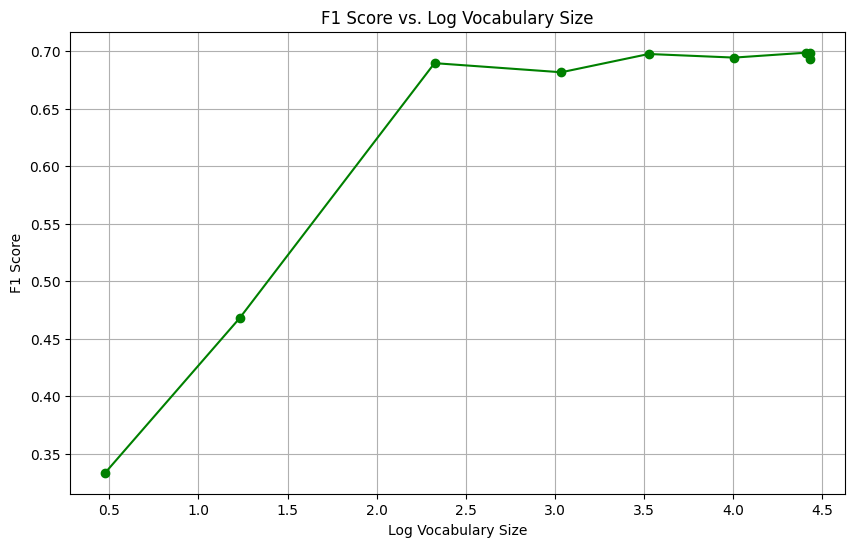

In [32]:
def Q6():

    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### START ###

    # Define the regularization strengths
    c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

    # Initialize empty lists to store

    # Prepare to collect results for plotting
    f1_scores = []
    vocab_sizes = []

    # Original vectorizer for full vocabulary
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    feature_names = vectorizer.get_feature_names_out()

    for c in c_values:
        # Step 1: Train a Logistic Regression model with L1 penalty
        lr_l1 = LogisticRegression(C=c, penalty='l1', solver="liblinear", tol=0.015)
        lr_l1.fit(X_train, train_labels)

        # Step 2: Analyze LR model's coefficients, find the tokens with non-zero weights, keep them
        non_zero_indices = np.where(np.sum(np.abs(lr_l1.coef_), axis=0) != 0)[0]

        if len(non_zero_indices) == 0:
            # Skip this C value if no features are selected
            continue

        # Step 3: Build a new vocabulary made up of only the non-zero weighted features
        new_vocab = {feature_names[i]: idx for idx, i in enumerate(non_zero_indices)}

        # Step 4: Transform data with a new CountVectorizer, pass new vocab in
        vectorizer_reduced = CountVectorizer(vocabulary=new_vocab)
        X_train_reduced = vectorizer_reduced.fit_transform(train_data)
        X_dev_reduced = vectorizer_reduced.transform(dev_data)

        # Step 5: Train a new LR (with L2 penalty) model with the transformed data using CountVectorizer from step 4
        lr_l2 = LogisticRegression(C=0.5, penalty='l2', solver="liblinear", tol=0.015)
        lr_l2.fit(X_train_reduced, train_labels)

        # Evaluate and show the L1 regularization strength, vocabulary size, and f1 score
        pred_dev = lr_l2.predict(X_dev_reduced)
        f1_score = metrics.f1_score(dev_labels, pred_dev, average="weighted")
        f1_scores.append(f1_score)
        vocab_sizes.append(len(new_vocab))

        print(f"L1 Regularization Strength: {c}")
        print(f"Reduced Vocabulary Size: {len(new_vocab)}")
        print(f"F1 Score: {f1_score}")

    # Plot f1 score vs. log vocabulary size
    plt.figure(figsize=(10, 6))
    plt.plot(np.log10(vocab_sizes), f1_scores, marker='o', color='g')
    plt.xlabel('Log Vocabulary Size')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Log Vocabulary Size')
    plt.grid(True)
    plt.show()

    ### END ###

Q6()

ANSWER:

- The F1 Score improves as the L1 regularization strength increases up to approximately 0.25. Beyond this point, the F1 Score begins to level. While reducing the vocabulary size can enhance the F1 Score, there is a balance between the size of the vocabulary and model performance. The model achieving the highest F1 Score of 0.706 uses a vocabulary of 25,371 words and an L1 regularization strength of 1000, indicating an optimal level of L1 penalty for feature reduction. Increasing the penalty beyond this optimal level does not further improve the model's performance significantly.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

F1 Score: 0.7597662427853104
Document 607:
R ratio: 287.3073187500546
Text: 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


Document 665:
R ratio: 325.00379098431364
Text: Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

Document 215:
R ratio: 929.3567160108051
Text: I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previ

<ipython-input-33-855a5f863a6f>:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(R_ratio, 'bo', color='g')


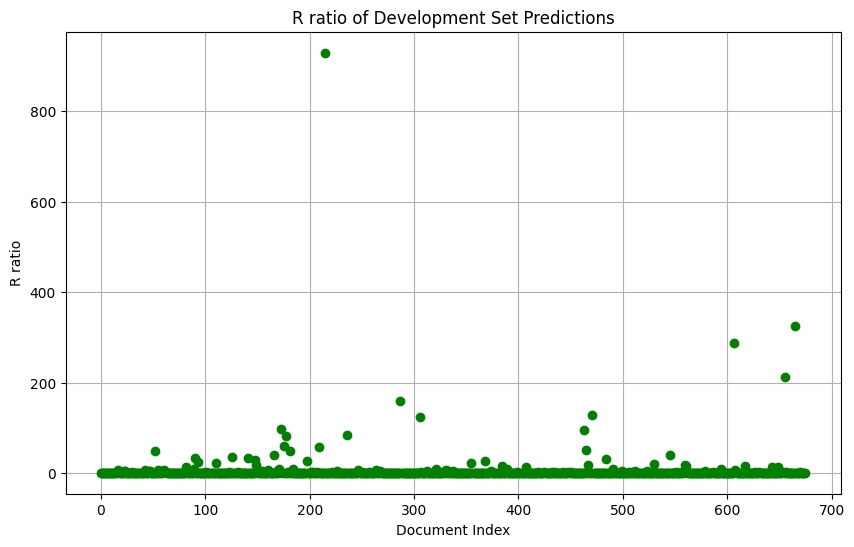

In [33]:
def Q7():

    ### STUDENT START ###

    # Step 1: Transform the training data into tf-idf form
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_dev_tfidf = vectorizer.transform(dev_data)

    # Step 2: Train a Logistic Regression model with L2 regularization strength of 100
    lr = LogisticRegression(C=100, solver="liblinear", multi_class="auto")
    lr.fit(X_train_tfidf, train_labels)

    # Step 3: Evaluate the model and show the f1 score
    dev_predictions = lr.predict(X_dev_tfidf)
    f1_score = metrics.f1_score(dev_labels, dev_predictions, average="weighted")
    print(f"F1 Score: {f1_score}")

    # Step 4: Compute and show 3 documents with the highest R ratio
    dev_probabilities = lr.predict_proba(X_dev_tfidf)
    max_prob = np.max(dev_probabilities, axis=1)
    correct_prob = dev_probabilities[np.arange(len(dev_labels)), dev_labels]
    R_ratio = max_prob / correct_prob
    top_3_indices = np.argsort(R_ratio)[-3:]

    for index in top_3_indices:
        print(f"Document {index}:")
        print(f"R ratio: {R_ratio[index]}")
        print(f"Text: {dev_data[index]}")
        print()

    # Plot R ratios to analyze further [optional]
    plt.figure(figsize=(10, 6))
    plt.plot(R_ratio, 'bo', color='g')
    plt.xlabel('Document Index')
    plt.ylabel('R ratio')
    plt.title('R ratio of Development Set Predictions')
    plt.grid(True)
    plt.show()

    ### STUDENT END ###

Q7()

ANSWER:

- Compare TfidfVectorizer with CountVectorizer: TfidfVectorizer calculates term frequency-inverse document frequency for each term, while CountVectorizer counts the number of times each term appears in the document.

- R ratio: describes the confidence of the most probable class relative to the confidence of the correct class. High R ratios indicate that the model is very confident in a prediction that is likely incorrect, a potential misclassification or uncertainty.

- Mistakes is the model making: Misclassifies religious texts, particularly Mormon-related content. Struggles with distinguishing between words that are the main topic of the document, and those that can be found in references for example. Potential solution: Incorporate domain-specific features or use topic modeling techniques to better capture contextual information and improve classification accuracy for religious and similar content categories.

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.